train_id : 데이터_id

name : 제품명

category_name : 카테고리 명

brand_name : 브랜드 이름

shipping : 배송비 무료 여부.

item_description : 제품에 대한 설명

train_id or test_id - the id of the listing

name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

item_condition_id - the condition of the items provided by the seller

category_name - category of the listing

brand_name

price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

shipping - 1 if shipping fee is paid by seller and 0 by buyer

item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

In [ ]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
mercari = pd.read_csv('/content/drive/MyDrive/train.tsv', sep = '\t')

In [ ]:
mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
mercari.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [ ]:
mercari.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

## Price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


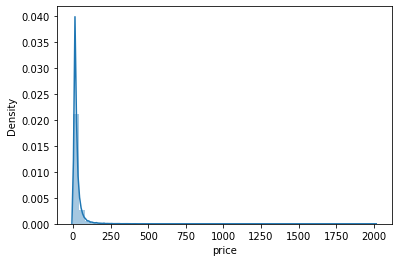

In [ ]:
sns.distplot(mercari['price'])

In [ ]:
mercari['price'] = mercari['price'].apply(lambda x : np.log1p(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


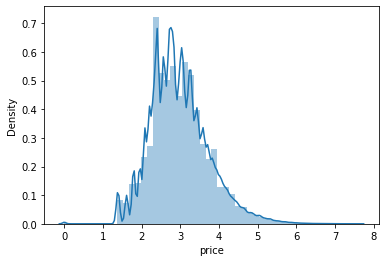

In [ ]:
sns.distplot(mercari['price'])

## Shipping

In [ ]:
import plotly.express as px
px.pie(mercari, values = mercari.groupby('shipping')['name'].count(), names = list(set(mercari['shipping'].values)))


## item_condition_id

In [ ]:
px.pie(mercari, values = mercari.groupby('item_condition_id')['name'].count(), names = list(set(mercari['item_condition_id'].values)))

## category_name

In [ ]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari['cat_dae'], mercari['cat_jung'], mercari['cat_so'] = \
                        zip(*mercari['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari['cat_dae'].value_counts())
print('중분류 갯수 :', mercari['cat_jung'].nunique())
print('소분류 갯수 :', mercari['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


In [ ]:
mercari['cat_so'].value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Cleaning                       1
Garbage Disposals              1
Crib Netting                   1
Map                            1
Pad                            1
Name: cat_so, Length: 871, dtype: int64

In [ ]:
px.pie(mercari, values = mercari.groupby('cat_dae')['name'].count(), names = list(set(mercari['cat_dae'].values)))

In [ ]:
mercari['cat_so'].value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Cleaning                       1
Garbage Disposals              1
Crib Netting                   1
Map                            1
Pad                            1
Name: cat_so, Length: 871, dtype: int64

In [ ]:
cat_so = mercari.groupby('cat_so').count()
px.bar(cat_so, x= cat_so.index, y = 'name')

## 결측치 채우기

In [ ]:
mercari['brand_name'] = mercari['brand_name'].fillna(value = 'Ohter_Null')
mercari['category_name'] = mercari['category_name'].fillna(value = 'Ohter_Null')
mercari['item_description'] = mercari['item_description'].fillna(value = 'Ohter_Null')

In [ ]:
mercari.isna().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## brand_name, name

In [ ]:
print('brand_name의 유형건수 : ', len(set(mercari['brand_name'])))
print('brand_name sample : ', mercari['brand_name'].value_counts()[:5])

brand_name의 유형건수 :  4810
brand_name sample :  Ohter_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [ ]:
print('name의 유형건수 : ', len(set(mercari['name'])))
print('name sample : ', mercari['name'][:5])

name의 유형건수 :  1225273
name sample :  0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
Name: name, dtype: object


In [ ]:
CV = CountVectorizer()
name = CV.fit_transform(mercari.name)
print(name.shape)

(1482535, 105757)


## item_description

In [ ]:
print('item_description 평균 문자열 갯수 : ', mercari['item_description'].str.len().mean())
mercari['item_description'][:2]

item_description 평균 문자열 갯수 :  145.7113889385411


0                                   No description yet
1    This keyboard is in great condition and works ...
Name: item_description, dtype: object

In [ ]:
TF = TfidfVectorizer(max_features = 50000, ngram_range = (1, 3), stop_words = 'english')
description = TF.fit_transform(mercari.item_description)
print(description.shape)

(1482535, 50000)


## 원핫 인코딩

In [ ]:
from sklearn.preprocessing import LabelBinarizer

LB = LabelBinarizer(sparse_output = True)

brand = LB.fit_transform(mercari['brand_name'])
condition = LB.fit_transform(mercari['item_condition_id'])
shipping = LB.fit_transform(mercari['shipping'])
cat_dae = LB.fit_transform(mercari['cat_dae'])
cat_jung = LB.fit_transform(mercari['cat_jung'])
cat_so = LB.fit_transform(mercari['cat_so'])

In [ ]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (name, description, brand, condition, shipping, cat_dae, cat_jung, cat_so)
X_feature_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_feature_sparse), X_feature_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_feature_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


31062

## 릿지 회귀 모델 구축 및 평가

In [ ]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [ ]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

In [ ]:
linear_model = Ridge(solver = 'lsqr', fit_intercept = False)
sparse_matrix_list = (name, description, brand, condition, shipping, cat_dae, cat_jung, cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('rmsle : ', evaluate_org_price(y_test, linear_preds))

rmsle :  0.471222915661763


In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (name, description, brand, condition, shipping, cat_dae, cat_jung, cat_so)

lgb = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgb, matrix_list = sparse_matrix_list)
print('LightGBM rmsle : ', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle :  0.45795650650262837


In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4509324141140827
